In [1]:
import numpy as np
import torch
import random
import cv2
import matplotlib.pyplot as plt

In [2]:
#====================Random seed====================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 100% deterministic but slower training
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [3]:
#====================Processing data====================

!wget https://github.com/richzhang/colorization/raw/caffe/colorization/resources/pts_in_hull.npy -O pts_in_hull.npy
# ab_bins = torch.from_numpy(np.load("/kaggle/working/pts_in_hull.npy", allow_pickle=True)).to(torch.float32)

# loading 313 to 32
from sklearn.cluster import KMeans

# Load 313 bin centers
ab313 = np.load("pts_in_hull.npy")   # shape (313, 2)

# Re-cluster them into 32 bins
kmeans = KMeans(n_clusters=32, random_state=0).fit(ab313)

ab32 = kmeans.cluster_centers_   # shape (32,2)
np.save("pts_in_hull_32.npy", ab32)

ab_bins = torch.from_numpy(np.load("/kaggle/working/pts_in_hull_32.npy", allow_pickle=True)).to(torch.float32)

--2025-10-02 09:20:04--  https://github.com/richzhang/colorization/raw/caffe/colorization/resources/pts_in_hull.npy
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/richzhang/colorization/caffe/colorization/resources/pts_in_hull.npy [following]
--2025-10-02 09:20:04--  https://raw.githubusercontent.com/richzhang/colorization/caffe/colorization/resources/pts_in_hull.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5088 (5.0K) [application/octet-stream]
Saving to: ‘pts_in_hull.npy’

pts_in_hull.npy     100%[===================>]   4.97K  --.-KB/s    in 0s      

2025-10-02 09:20:05 (40.8 MB/s)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


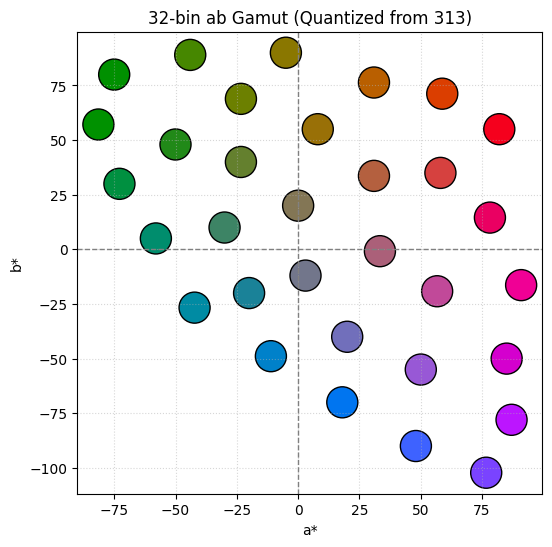

In [4]:
#====================Bins Plott====================

def plot_ab_gamut(ab_bins, L=50, point_size=500):
    """
    Plot ab bins like in Zhang et al. paper (scatter in ab plane).
    Each point is colored by converting Lab -> RGB for visualization.
    """
    colors = []
    for ab in ab_bins:
        Lab = np.array([[[L, ab[0], ab[1]]]], dtype=np.float32)
        rgb = cv2.cvtColor(Lab, cv2.COLOR_Lab2RGB)
        rgb = np.clip(rgb, 0, 1)
        colors.append(rgb[0,0])  # extract RGB triplet

    colors = np.array(colors)

    plt.figure(figsize=(6,6))
    plt.scatter(ab_bins[:,0], ab_bins[:,1], 
                c=colors, s=point_size, edgecolors='k')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel("a*")
    plt.ylabel("b*")
    plt.title("32-bin ab Gamut (Quantized from 313)")
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.show()

# usage
plot_ab_gamut(ab_bins, L=50)


In [5]:
#====================Processing data====================
def soft_encode_ab(ab, topk=5, sigma=5.0):
    # ab: [H,W,2] float32, đơn vị ~[-128,127]
    H, W, _ = ab.shape
    ab_flat = ab.reshape(-1, 2)                                      # [H*W,2]
    dists = torch.cdist(ab_flat, ab_bins.to(ab.device))              # [N,Q]
    vals, idxs = torch.topk(dists, k=topk, largest=False, dim=1)
    w = torch.exp(-(vals**2) / (2*(sigma**2))); w = torch.softmax(w, dim=1)
    Z = torch.zeros((ab_flat.size(0), ab_bins.size(0)), device=ab.device)
    Z.scatter_(1, idxs, w)
    Z = Z.view(H, W, -1).permute(2,0,1).contiguous()                 # [Q,H,W]
    return Z


def soft_decode(z, T):
    zT = torch.softmax(torch.log(z + 1e-8)/T, dim=1)
    a = (zT * ab_bins[:,0][None,:,None,None]).sum(1)  # [B,H,W]
    b = (zT * ab_bins[:,1][None,:,None,None]).sum(1)  # [B,H,W]
    ab_hat = torch.stack([a, b], dim=1)        # [B,2,H,W]
    return ab_hat


import torch.nn.functional as F
import scipy.ndimage.interpolation as sni
#reduce by 4x
def downsampling(img):
    """
    Input shape: [4H, 4W, C]
    Output shape: [H, W, C]
    """
    return F.avg_pool2d(img.permute(2, 0, 1), kernel_size=4, stride=4).permute(1, 2, 0)
#upsize by 4
def upsampling(img):
    """
    Input shape: [C, H/4, W/4]
    Output shape: [C, H, W]
    """
    return torch.from_numpy(sni.zoom(img,(1, 1, 4., 4.)))

In [6]:
#====================Dataset====================
import cv2
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

batch_size = 512

class dataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, _ = self.data[idx]
        lab = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2LAB)   # uint8 Lab
        L  = lab[..., 0:1].astype(np.float32) / 100.0          # [0, 1]
        ab = lab[..., 1:3].astype(np.float32) - 128.0          # [-128,127]
        L, ab = torch.from_numpy(L).to(torch.float32), torch.from_numpy(ab).to(torch.float32)
        X, Z = L.permute(2, 0, 1), soft_encode_ab(ab)
        return X, Z

train_dataset = dataset(datasets.CIFAR10(root="./data", train=True, download=True))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dataset = dataset(datasets.CIFAR10(root="./data", train=False, download=True))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

100%|██████████| 170M/170M [00:12<00:00, 14.1MB/s]


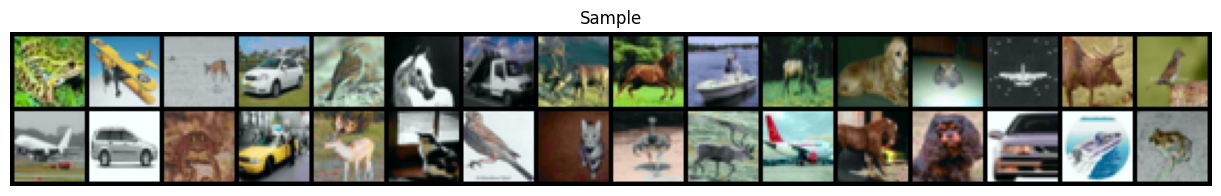

In [7]:
#====================Show data====================
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def imshow(L, ab, title):
    #scaling back from RGB -> LAB
    """
    L: [B,1,H,W], range [0,100]
    ab: [B,2,H,W], range [-128,127]
    """
    L = L
    ab = ab + 128
    
    img = np.concatenate([L.numpy(), ab.numpy()], axis=1) # unnormalize
    img = img[:32, :, :, :]

    
    img = np.transpose(img, (0, 2, 3, 1))
    img = np.clip(np.rint(img), 0, 255).astype(np.uint8)
    img = [torch.from_numpy(cv2.cvtColor(img[i], cv2.COLOR_LAB2RGB)).permute(2, 0, 1) for i in range(len(img))] # conver lab to rgb
    img = torch.stack(img, dim=0)


    #plot
    grid = make_grid(img, nrow=16, padding=2)
    plt.figure(figsize=(16,2))
    plt.imshow(grid.permute(1,2,0).numpy()) 
    plt.title(title)
    plt.axis('off')
    plt.show()

X, Z = next(iter(train_dataloader))
L, ab = X*100, soft_decode(Z, T = 1)
imshow(L, ab, "Sample")



In [8]:
#====================Model====================
import torch.nn as nn
# ---------------- Encoder Block ---------------- #
class DownConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(out_ch)
        )
    def forward(self, x):
        x = self.block(x)
        return x

    

# ---------------- Decoder Block ---------------- #
class UpConv(nn.Module):
    def __init__(self, in_ch, out_ch, bottle_neck = False):
        super().__init__()
        self.bottle_neck = bottle_neck
        self.up = nn.ConvTranspose2d(in_ch*(2-bottle_neck), in_ch*(2-bottle_neck), kernel_size=3, stride=2, padding = 1, output_padding = 1)
        self.block = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(in_ch*(2-bottle_neck), in_ch*(2-bottle_neck), kernel_size=3, stride = 1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch*(2-bottle_neck), out_ch, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_ch)
        )

    def forward(self, x, skip = None):
        if self.bottle_neck == False:
            x = torch.cat([skip, x], dim=1)

        # print(x.shape)
        x = self.up(x)
        # print(x.shape)
        
        return self.block(x)


#----------------- Output Block ---------------- #
class OutputBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=3, stride=2, padding = 1, output_padding = 1)
        self.block = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(in_ch, in_ch, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, kernel_size = 1, stride = 1, padding = 0)
        )

    def forward(self, x):
        x = self.up(x)
        return self.block(x)

# ---------------- U-Net ---------------- #
class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=2):  # input L channel, output ab channels
        super().__init__()
        # ---------------- Encoder ----------------
        self.enc1 = DownConv(in_ch, 16)    
        self.enc2 = DownConv(16, 32)      
        self.enc3 = DownConv(32, 64)     
        

        # ---------------- Decoder ----------------
        self.dec3 = UpConv(64, 32, bottle_neck = True)     
        self.dec2 = UpConv(32, 16)
        

        # ---------------- Output ----------------
        self.final = OutputBlock(16, 32)   

    def forward(self, x):
        # ----- Encoding path -----
        s1 = self.enc1(x)   
        s2 = self.enc2(s1)  
        s3 = self.enc3(s2)  
    
        # ----- Decoding path -----
        
        d3 = self.dec3(s3)  
        d2 = self.dec2(d3, s2)  
        
          
        # ----- Output -----
        out = self.final(d2)    
        return out


In [9]:
#====================Shape check====================
test = UNet()
data, label = next(iter(train_dataloader))

print(data.shape, label.shape)
print(test(data).shape)

torch.Size([512, 1, 32, 32]) torch.Size([512, 32, 32, 32])
torch.Size([512, 32, 32, 32])


In [10]:
#====================Compute weight====================
from scipy.ndimage import gaussian_filter1d

p = torch.zeros(32)
sigma = 5; lam = 0.5; Q = len(p)

for img, label in train_dataloader:
    p += label.sum(dim=[0, 2, 3])

# normalize input distribution
p = p / p.sum()

# smooth distribution with Gaussian kernel
# (here 1D Gaussian filter, assuming p is already binned histogram)
p_tilde = gaussian_filter1d(p, sigma=sigma)
p_tilde = p_tilde / p_tilde.sum()
mixed = (1 - lam) * p_tilde + lam / Q

# take reciprocal
w = 1.0 / mixed

# normalize so expectation E[w] = 1 under p_tilde
w = w / np.sum(p_tilde * w)
w = torch.from_numpy(w)
p_tilde = torch.from_numpy(p_tilde)
(p_tilde * w).sum()

tensor(1.)

In [11]:
#====================Custom loss function====================
import torch.nn.functional as F

class RebalanceCEWithLogitsLoss(torch.nn.Module):
    """
    L_cl(Zhat, Z) = - sum_{h,w} v(Z_{h,w}) * sum_q Z_{h,w,q} * log Zhat_{h,w,q}
    - Zhat: logits từ mạng (B, Q, H, W)   # sẽ softmax theo Q
    - Z:    target soft-encoding (B, Q, H, W) hoặc hard labels (B, H, W)
    - w:    class weights (Q,) từ compute_class_weights(...)
            v(Z_{h,w}) = w[q*], với q* là bin gần nhất (argmax của Z)
    """
    def __init__(self, class_weights, reduction: str = "mean", eps: float = 1e-8):
        super().__init__()
        self.reduction = reduction
        self.eps = eps
        self.register_buffer("w", torch.as_tensor(class_weights, dtype=torch.float32))

    def forward(self, logits, target):
        """
        Args:
            logits: (B, Q, H, W)
            target: (B, Q, H, W) soft-encoding
        """
        B, Q, H, W = logits.shape
        log_probs = F.log_softmax(logits, dim=1)  # (B,Q,H,W)
        q_star = target.argmax(dim=1)  # (B,H,W)
        ce_per_pixel = -(target * log_probs).sum(dim=1)  # (B,H,W)
        weights = self.w[q_star]  # (B,H,W)
        loss_per_pixel = weights * ce_per_pixel  # (B,H,W)

        if self.reduction == "mean":
            return loss_per_pixel.sum() / (weights.sum() + self.eps)
        elif self.reduction == "sum":
            return loss_per_pixel.sum()
        else:
            return loss_per_pixel

In [12]:
#====================Training setup====================
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constant
EPOCHS = 200

# Model, optimizer, loss function
model = UNet().to(device)
criterion = RebalanceCEWithLogitsLoss(class_weights=w, reduction="mean").to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-3, lr=1e-2)
device


device(type='cuda')

In [13]:
from tqdm import tqdm

# ================== Train loop ==================
for epoch in range(1, EPOCHS + 1):
    # ---- Training ----
    model.train()
    train_loss = 0.0

    loop = tqdm(train_dataloader, leave=False, desc=f"Epoch {epoch}/{EPOCHS} [Train]")
    for img, target in loop:
        img, target = img.to(device), target.to(device)

        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * img.size(0)

        # update tqdm bar with current loss
        loop.set_postfix(loss=loss.item())

    train_loss /= len(train_dataloader.dataset)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0

    loop_val = tqdm(test_dataloader, leave=False, desc=f"Epoch {epoch}/{EPOCHS} [Val]")
    with torch.no_grad():
        for img, target in loop_val:
            img, target = img.to(device), target.to(device)
            pred = model(img)
            loss = criterion(pred, target)
            val_loss += loss.item() * img.size(0)

            loop_val.set_postfix(loss=loss.item())

    val_loss /= len(test_dataloader.dataset)

    # ---- Logging ----
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | "
              f"Train Loss: {train_loss:.6f} | "
              f"Val Loss: {val_loss:.6f}")

        # save checkpoint every 10 epochs
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch}.pth")

Epoch 001 | Train Loss: 2.307940 | Val Loss: 2.248052


Epoch 010 | Train Loss: 2.172014 | Val Loss: 2.197755


Epoch 020 | Train Loss: 2.171097 | Val Loss: 2.181192


Epoch 030 | Train Loss: 2.168856 | Val Loss: 2.294428


Epoch 040 | Train Loss: 2.169859 | Val Loss: 2.237507


Epoch 050 | Train Loss: 2.168100 | Val Loss: 2.209661


Epoch 060 | Train Loss: 2.169100 | Val Loss: 2.260130


Epoch 070 | Train Loss: 2.167939 | Val Loss: 2.181516


Epoch 080 | Train Loss: 2.166997 | Val Loss: 2.198291


Epoch 090 | Train Loss: 2.166849 | Val Loss: 2.178267


Epoch 100 | Train Loss: 2.166782 | Val Loss: 2.170035


Epoch 110 | Train Loss: 2.168737 | Val Loss: 2.189154


Epoch 120 | Train Loss: 2.167029 | Val Loss: 2.223430


Epoch 130 | Train Loss: 2.167011 | Val Loss: 2.187785


Epoch 140 | Train Loss: 2.167178 | Val Loss: 2.203818


Epoch 150 | Train Loss: 2.168105 | Val Loss: 2.191188


Epoch 160 | Train Loss: 2.167093 | Val Loss: 2.231636


Epoch 170 | Train Loss: 2.167740 | Val Loss: 2.190893


Epoch 180 | Train Loss: 2.168106 | Val Loss: 2.183650


Epoch 190 | Train Loss: 2.168598 | Val Loss: 2.289683


Epoch 200 | Train Loss: 2.172206 | Val Loss: 2.178507


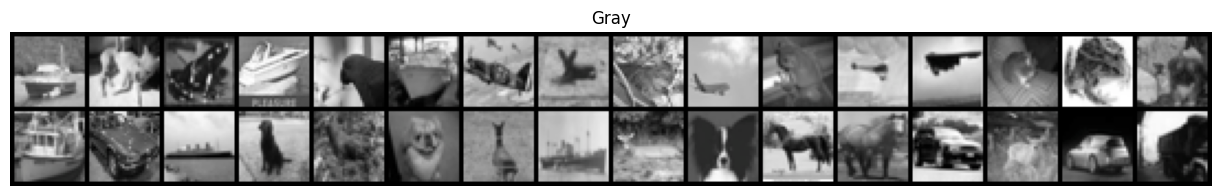


=== Loading checkpoint 50 ===


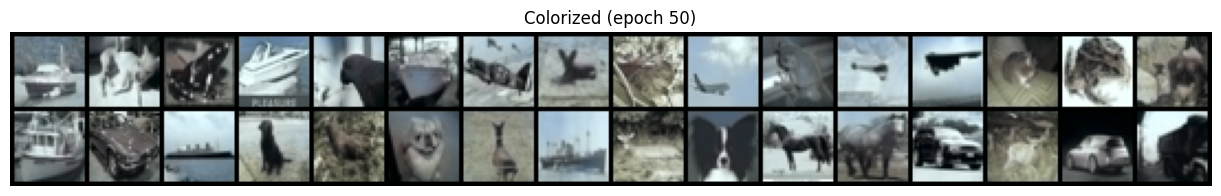


=== Loading checkpoint 100 ===


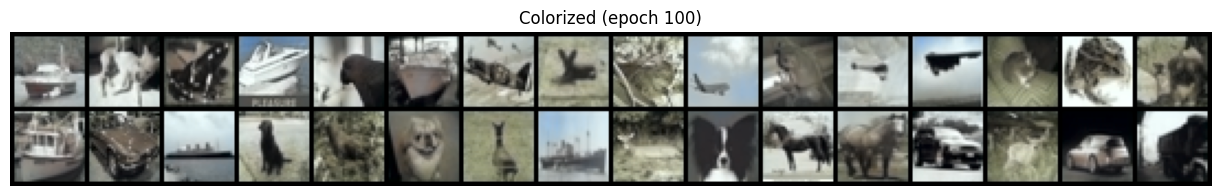


=== Loading checkpoint 150 ===


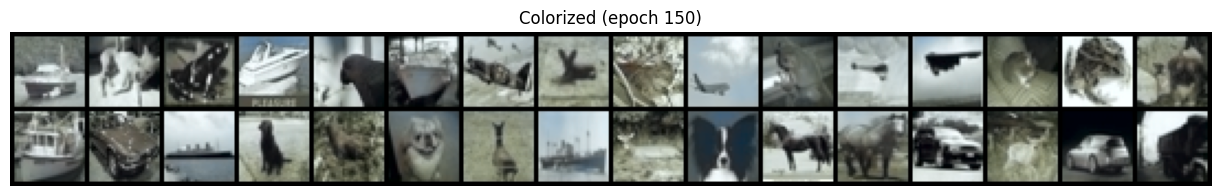


=== Loading checkpoint 200 ===


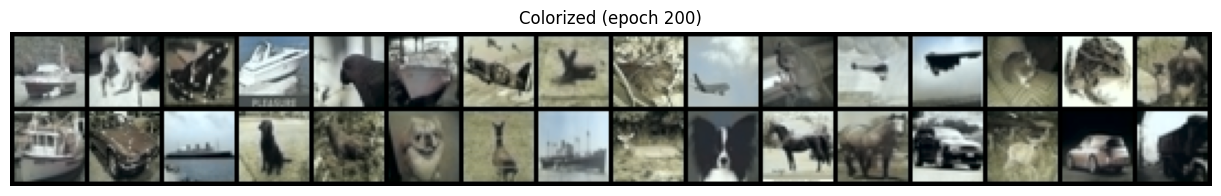

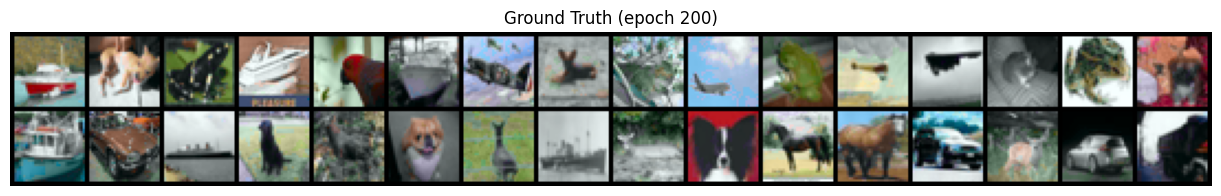

In [14]:
#======================== Inference ===================
checkpoints = [50, 100, 150, 200]

L_fixed, Z_fixed = next(iter(test_dataloader))
Z = torch.softmax(model(L_fixed.to(device)), dim=1)
L = (L_fixed * 100).cpu()
ab_hat = soft_decode(Z.cpu(), T= 0.38)   # [B,2,H,W]
imshow(L, torch.zeros_like(ab_hat), title=f"Gray")



for ckpt in checkpoints:
    print(f"\n=== Loading checkpoint {ckpt} ===")
    
    model = UNet().to(device)
    state = torch.load(f"checkpoint_epoch_{ckpt}.pth", map_location=device)
    model.load_state_dict(state, strict=False)
    model.eval()
    
    with torch.no_grad():
        # Scale L back for LAB conversion
        L = (L_fixed * 100).cpu()

        Z = torch.softmax(model(L_fixed.to(device)), dim=1)
        ab_hat = soft_decode(Z.cpu(), T= 0.38)   # [B,2,H,W]
        
        imshow(L, ab_hat, title=f"Colorized (epoch {ckpt})")

L = (L_fixed * 100).cpu()
ab_fixed = soft_decode(Z_fixed, T=1)  
imshow(L, ab_fixed, title=f"Ground Truth (epoch {ckpt})")